In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
plt.style.use('dark_background')

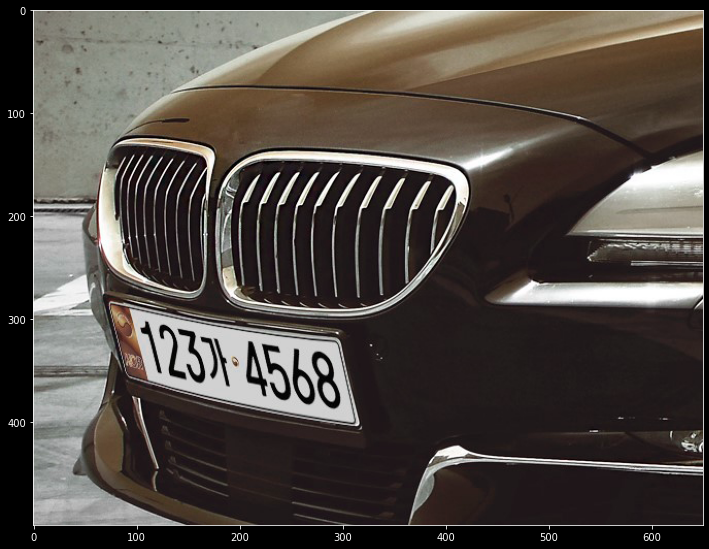

In [11]:
img_ori = cv2.imread('0.jpg')

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')

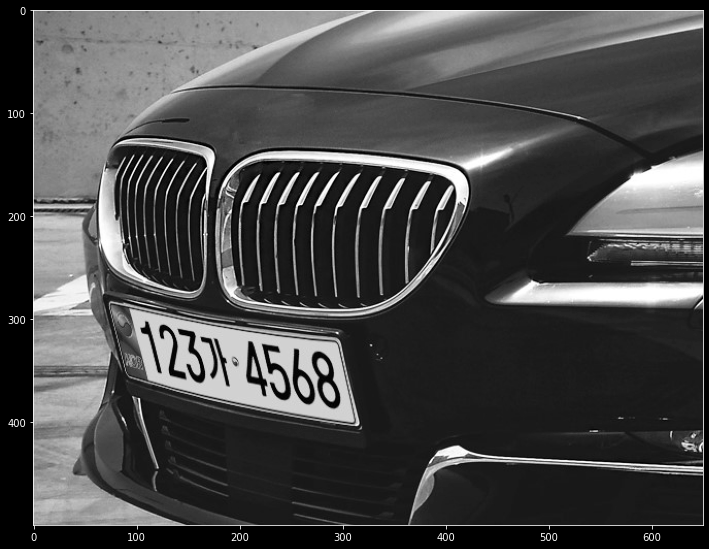

In [12]:
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

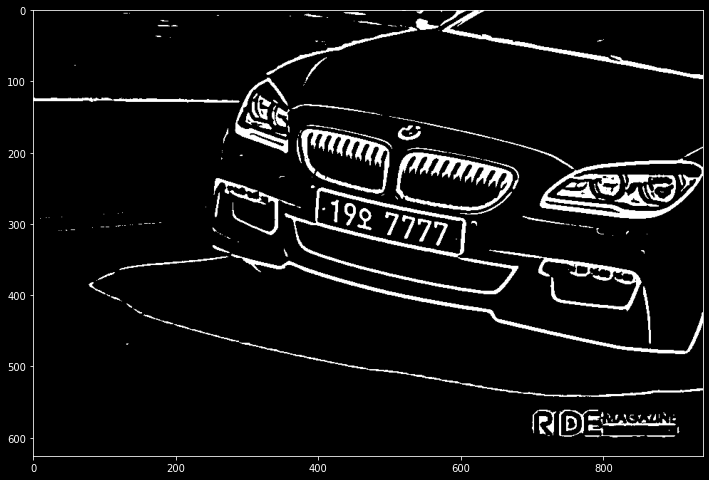

In [4]:
#노이즈 줄이기 위해서
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

#이미지의 Threshold 지정하여 예로 그래프 곡선이면 임의의 값 255 지정 해버리면 Threshold 보다 낮은값은 0으로 취급 Threshold 보다 높은값은 255로 고정 이미지를 구분하기 쉽게 만드는 용도
img_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

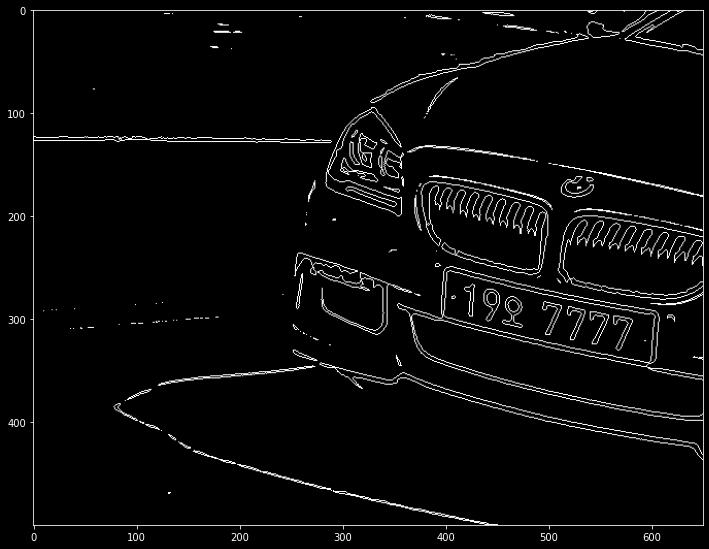

In [13]:
#윤곽선 그리기 / contourldx에 -1의 값을 줘서 전체 contours를 그림
contours,_ = cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)


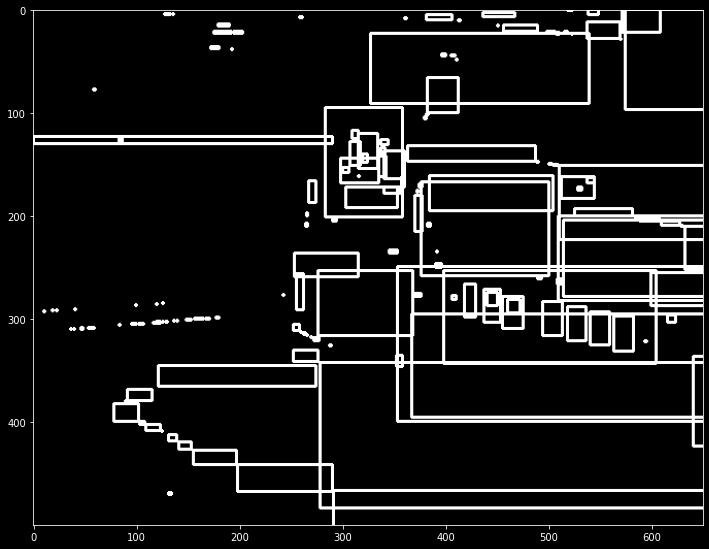

In [14]:
#번호판 쉽게 찾기 위해 조정
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)   #boundingRect함수 사용해서 contour를 감싸는 사각형을 만듬
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

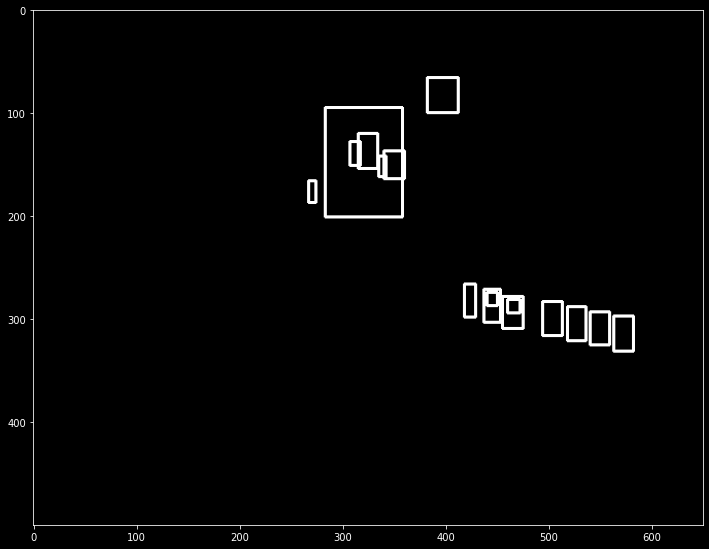

In [15]:
#boundingRect의 크기 지정
MIN_AREA = 80   #면적
MIN_WIDTH, MIN_HEIGHT = 2, 8   #너비, 높이
MIN_RATIO, MAX_RATIO = 0.25, 1.0   #비율

possible_contours = []   #크기 지정하고 가능한 것을 possible_contours에 저장

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']

#조건 걸어서 비교해가며 조건에 맞는 거만 번호판의 확률이 높다고 지정
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)   #번호판일 확률이 높은 것을 저장, 각 윤곽선에 idx값 지정해서 나중에 조건에 맞는 값만 따로 빼서 지정
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

In [ ]:
#차량 번호판의 일정한 간격, 배열 등을 비교하여 분석
MAX_DIAG_MULTIPLYER = 5   #contour 각각의 중심을 기준으로 대각선의 가로 길이만큼 5배 이내
MAX_ANGLE_DIFF = 12.0   #contour 각각의 중심을 기준으로 각도를 12도 이내
MAX_AREA_DIFF = 0.5   #contour 각각의 면적 차이를 0.5 이내
MAX_WIDTH_DIFF = 0.8   #contour 각각의 너비 차이를 0.8 이내
MAX_HEIGHT_DIFF = 0.2   #contour 각각의 높이 차이를 0.2 이내
MIN_N_MATCHED = 3   #contour 각각의 번호판으로 추정되는 후보들을 위의 조건을 3개 미만이면 번호판 x, 3개 만족하면 번호판으로 판정

def find_chars(contours_list):
    matched_result_idx = []

    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)   #contour의 내부 대각선 길이

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']])) - np.array([d2['cx'], d2['cy']])   #numpy의 linalg.norm함수 사용하여 contour 각각의 중심을 기준으로 피타고라스 정의 c길이
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))   #numpy의 degrees함수 사용 tan0 = dy / dx 인데 역함수해서 0 = arctan(dy / dx)
            area_diff = abs(d1['w'] + d1['h'] - d2['w'] * d2['h'] / (d1['w'] * d1['h']))   #면적의 비율
            width_diff = abs(d1['w'] - d2['w'] / d1['w'])   #너비의 비율
            height_diff = abs(d1['h'] - d2['h'] / d1['h'])   #높이의 비율

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])